# Introduction

The prediction of future global temperatures is a critical aspect of climate research and policy-making. By accurately forecasting temperature trends, we can gain valuable insights into the potential impacts of climate change and make informed decisions to mitigate its effects. In this study, we explore the use of ARIMA (Autoregressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) models to forecast global temperature values based solely on historical temperature data.

The dataset used in this analysis is sourced from Berkeley Earth, an organization affiliated with Lawrence Berkeley National Laboratory. This dataset provides comprehensive and reliable surface temperature measurements from various locations across the globe. The data can be accessed from the following Kaggle repository: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data.

The primary objective of this study is to investigate the effectiveness of ARIMA and SARIMA models in capturing the temporal patterns and predicting future global temperature changes. These models are well-suited for time series analysis, as they can account for the autocorrelation and seasonality present in the temperature data.

By leveraging the historical temperature observations, we aim to develop accurate and robust forecasting models. The insights gained from these models can help us understand the long-term temperature trends, identify potential climate anomalies, and assess the efficacy of climate change mitigation strategies.

# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/home/veroastro/Documents/earth_temperature/data/GlobalTemperatures.csv')
data.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.dtypes

dt                                            object
LandAverageTemperature                       float64
LandAverageTemperatureUncertainty            float64
LandMaxTemperature                           float64
LandMaxTemperatureUncertainty                float64
LandMinTemperature                           float64
LandMinTemperatureUncertainty                float64
LandAndOceanAverageTemperature               float64
LandAndOceanAverageTemperatureUncertainty    float64
dtype: object

In [4]:
#changing the date column,dt, into a datetime object
data['dt']=pd.to_datetime(data['dt'])
data.dtypes

dt                                           datetime64[ns]
LandAverageTemperature                              float64
LandAverageTemperatureUncertainty                   float64
LandMaxTemperature                                  float64
LandMaxTemperatureUncertainty                       float64
LandMinTemperature                                  float64
LandMinTemperatureUncertainty                       float64
LandAndOceanAverageTemperature                      float64
LandAndOceanAverageTemperatureUncertainty           float64
dtype: object

In [5]:
data.isna().sum()

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

In [6]:
cols = ['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty']
land_avg_temp = data[cols].dropna()
land_avg_temp.isna().sum()

dt                                   0
LandAverageTemperature               0
LandAverageTemperatureUncertainty    0
dtype: int64

In [7]:
# creating the dataset of temperatures by year
land_avg_temp['years'] = pd.DatetimeIndex(land_avg_temp['dt']).year 
yearly = land_avg_temp.groupby('years').mean()
print(yearly.describe())


       LandAverageTemperature  LandAverageTemperatureUncertainty
count              266.000000                         266.000000
mean                 8.369337                           0.945719
std                  0.584921                           0.994110
min                  5.779833                           0.062083
25%                  8.081563                           0.210208
50%                  8.372167                           0.405583
75%                  8.704167                           1.629563
max                  9.831000                           4.026000


In [8]:
avg_temp = yearly['LandAverageTemperature'].drop(yearly.index[:100])
avg_temp.shape

(166,)

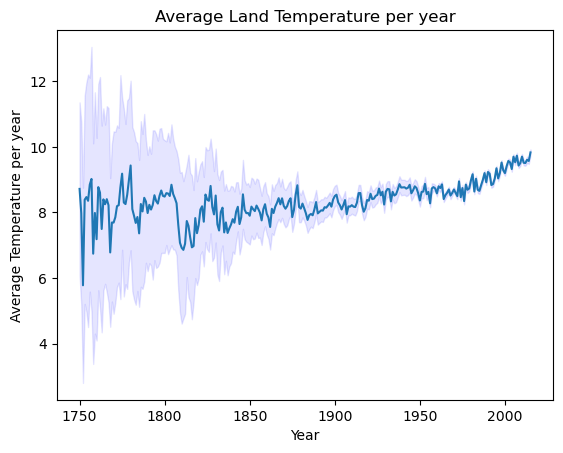

In [9]:
y = yearly['LandAverageTemperature']
unc = yearly['LandAverageTemperatureUncertainty']
yearly.index
plt.plot(y)
plt.fill_between(yearly.index,y+unc,y-unc,alpha=0.1, color='b' )
plt.title("Average Land Temperature per year")
plt.xlabel("Year")
plt.ylabel("Average Temperature per year")
plt.show()

# Analysis

## Data Preprocessing

In [10]:
# splitting the dataset into train and test datasets
size = len(avg_temp)
cutoff = int(size*0.7)
train = avg_temp[:cutoff]
test = avg_temp[cutoff:]
print('train:', train.shape)
print('test:', test.shape)

train: (116,)
test: (50,)


We start the count of the training dataset at 100 because of the big uncertainty and variation of the first 100 years of the dataset. The model predictions dont match the increasing trend in average temperatures. So the data we use is from 1850 instead of 1750.

In [11]:
from pmdarima.arima.stationarity import ADFTest
# Test whether we should difference at the alpha=0.05 significance level
adf_test = ADFTest(alpha=0.05)
p_val_all, should_diff_all= adf_test.should_diff(avg_temp)  # (0.01, False)
adf_test = ADFTest(alpha=0.05)
p_val_red, should_diff_red= adf_test.should_diff(avg_temp[100:]) 
print('pval all', p_val_all)
print(should_diff_all)
print('pval reduce 100', p_val_red)
print(should_diff_red)

pval all 0.45855212965288394
True
pval reduce 100 0.3812330783418376
True


Eliminating the first 100 years changes the p-value from 0.03 to 0.4 which changes the need to difference it becauset the time series becomes non-stationary.

## Building Models
### Using Arima

In [12]:
import pmdarima as pm

# auto-ARIMA
model = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

model.summary()

Performing stepwise search to minimize aic


/home/veroastro/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-39.956, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=823.691, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-21.759, Time=0.56 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-45.647, Time=0.91 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.90 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-45.728, Time=1.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=1.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.18 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-48.378, Time=1.09 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-26.930, Time=0.50 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-49.885, Time=1.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-28.644, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-46.416

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  116
Model:               SARIMAX(3, 0, 3)   Log Likelihood                  35.466
Date:                Wed, 03 May 2023   AIC                            -54.933
Time:                        20:37:13   BIC                            -32.904
Sample:                             0   HQIC                           -45.990
                                - 116                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4222      0.517      0.817      0.414      -0.591       1.435
ar.L1          0.4650      0.185      2.518      0.012       0.103       0.827
ar.L2         -0.1051      0.182     -0.578      0.563      -0.461       0.251
ar.L3          0.5895      0.136      4.346      0.000       0.324       0.855
ma.L1          0.0687      0.178      0.387      0.699      -0.279       0.417
ma.L2          0.1804      0.141      1.276      0.202      -0.097       0.457
ma.L3         -0.6094      0.094     -6.505      0.000      -0.793      -0.426
sigma2         0.0312      0.005      6.355      0.000       0.022       0.041
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 2.33
Prob(Q):                              0.81   Prob(JB):                         0.31
Heteroskedasticity (H):               0.64   Skew:                            -0.27
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

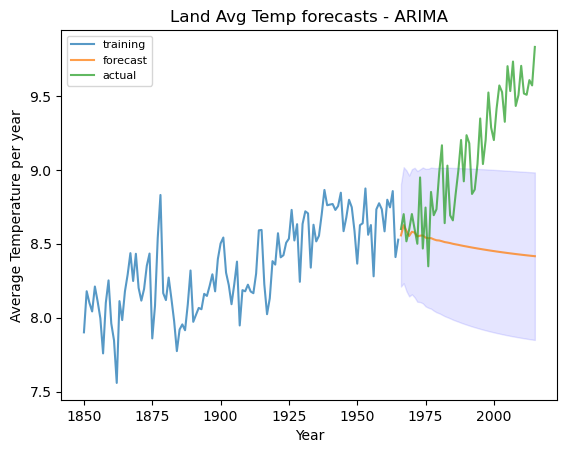

In [13]:
# Forecast
preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)

# plot the prediction and the actual test values
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 1850  # Year starts at 1850

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75, label='training')
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75, label='forecast')  # Forecasts
plt.plot(x_years[x_axis[train.shape[0]:]], test,alpha=0.75, label='actual')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Land Avg Temp forecasts - ARIMA")
plt.xlabel("Year")
plt.ylabel("Average Temperature per year")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [14]:
#Calculate the mean absolute percentage
mape = np.mean(np.abs(preds - test)/np.abs(test))
print((1-mape)*100) #print mape as an accuracy percentage

93.4240086769053


In [15]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(test,preds)))

0.7453520922453546


### Using SARIMA 
Adding seasonality to the model.

In [16]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=0, start_q=0, d=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, start_Q=0,
                          seasonal=True, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True, n_fits=50)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=50.187, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=27.294, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=42.983, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=15.317, Time=1.99 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.34 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=21.737, Time=0.86 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=10.487, Time=1.34 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=21.956, Time=0.56 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=18.88 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-13.959, Time=1.90 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-2.063, Time=0.75 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=13.13 s

In [17]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                  12.979
Date:                            Wed, 03 May 2023   AIC                            -13.959
Time:                                    20:38:21   BIC                              1.850
Sample:                                         0   HQIC                            -7.556
                                            - 116                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4711      0.108     -4.353      0.000      -0.683      -0.259
ar.L2         -0.4202      0.088     -4.797      0.000      -0.592      -0.249
ar.L3         -0.4843      0.089     -5.454      0.000      -0.658      -0.310
ar.S.L12      -0.5797      0.110     -5.255      0.000      -0.796      -0.363
ar.S.L24      -0.4115      0.125     -3.304      0.001      -0.656      -0.167
sigma2         0.0422      0.007      5.908      0.000       0.028       0.056
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.70
Prob(Q):                              0.99   Prob(JB):                         0.16
Heteroskedasticity (H):               0.74   Skew:                            -0.46
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

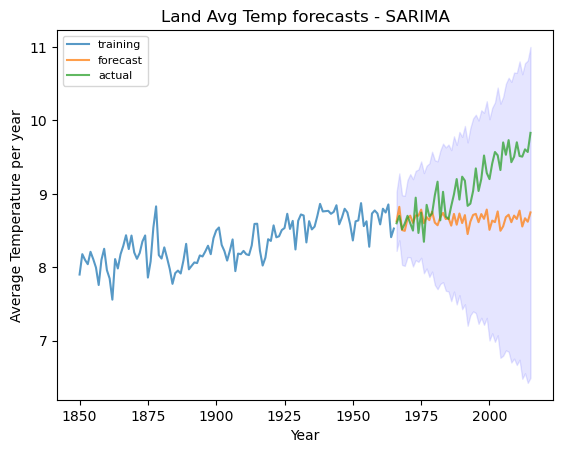

In [18]:
# Forecast
preds, conf_int = smodel.predict(n_periods=test.shape[0], return_conf_int=True)

# plot the prediction and the actual test values
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 1850  # Year starts at 1850

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75, label='training')
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75, label='forecast')  # Forecasts
plt.plot(x_years[x_axis[train.shape[0]:]], test,alpha=0.75, label='actual')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Land Avg Temp forecasts - SARIMA")
plt.xlabel("Year")
plt.ylabel("Average Temperature per year")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
#Calculate the mean absolute percentage
mape = np.mean(np.abs(preds - test)/np.abs(test))
print((1-mape)*100) #print mape as an accuracy percentage

94.97693374349248


In [20]:
print(np.sqrt(mean_squared_error(test,preds)))

0.5876993891219537


Using the Mean Absolute Percentage Error (MAPE), we have a 97.4% accuracy of the SARIMA model. Even if the mape of the ARIMA and SARIMA model are similar(97.4 and 97.2), from the images SARIMA seems to be doing a better job.  Looking at the image above it seems it under forcast the values of actual temperature after about the year 2000. 